# Feature Extraction for Phoneme Recognition on TIMIT

## Goals

- Loading and testing the datasets exported by the previous notebook.
- Feature design for the LSTM-250 network.
- Feature extraction from the TIMIT dataset.
- Exporting the features as standalone dataset for training the network.
    - Feature dataset record: (phoneme, feature-sequence)

# Environment Setup

In [1]:
import torch

import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.auto import tqdm


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1  Device: cuda


# Loading and Testing the Datasets

In [2]:
ds_path = './session/curated-dataset.pt'
ds_dict = torch.load(ds_path)
print(ds_dict.keys())
print(ds_dict['note'])

Train_ds = ds_dict['train']
Test_ds  = ds_dict['test']

print('Train_ds:', len(Train_ds))
ipd.display(Train_ds[:3])
print('Test_ds:', len(Test_ds))
ipd.display(Test_ds[:3])

dict_keys(['note', 'train', 'test'])

Notes:
- Phoneme record structure: (phoneme, path-to-audio, start-index, end-index)
- The dataset into train and test subsets.
- Some data is filtered according to a reference paper
    - SA records are removed from both datasets.
    - Only core test subset with 24 speakers are exported for testing.
    - Records missing phonetic-file (phoneme labels) are removed.
- Remapped phoneme from 61 to 39 classes.

Train_ds: 51848


[['h#', './dataset/TIMIT/data/TRAIN/DR4/MMDM0/SI1311.WAV', 0, 2680],
 ['s', './dataset/TIMIT/data/TRAIN/DR4/MMDM0/SI1311.WAV', 2680, 5640],
 ['aa', './dataset/TIMIT/data/TRAIN/DR4/MMDM0/SI1311.WAV', 5640, 7853]]

Test_ds: 7333


[['h#', './dataset/TIMIT/data/TEST/DR4/MTLS0/SX290.WAV', 0, 2370],
 ['dh', './dataset/TIMIT/data/TEST/DR4/MTLS0/SX290.WAV', 2370, 2780],
 ['ih', './dataset/TIMIT/data/TEST/DR4/MTLS0/SX290.WAV', 2780, 3880]]

In [3]:
rec = Train_ds[1]
phone, audio_path, start, end = rec
wave, rate = librosa.load(audio_path, sr=None)
phone_wave = wave[start:end]
print(phone)
ipd.display(ipd.Audio(phone_wave, rate=rate))

s


In [4]:
# delete redundant variables to avoid confusion
del ds_path, ds_dict
del rec, phone, audio_path, start, end, wave, rate, phone_wave

## Convert to Audio dataset

Convert records from (phoneme, path-to-audio, start-index, end-index) to (phoneme, wave, rate).

In [5]:
# Given a file path, returns the audio waveform and the sampling rate.
# Mainly used for caching already loaded files.
audio_cache = {}    # Caching loaded audio files for faster processing
def getAudio(audio_path):
    if audio_path not in audio_cache:
        wave, rate = librosa.load(audio_path, sr=None)    
        audio_cache[audio_path] = (wave, rate)
    return audio_cache[audio_path]


# Given file path, start, and end indices, returns the audio slice and the sampling rate
def getAudioSlice(audio_path, start, end):
    wave, rate = getAudio(audio_path)
    return wave[start:end], rate


# Without caching: 14 seconds
# With caching: < 1sec
# Test above function
for rec in tqdm(Train_ds):    
    _, audio_path, *_ = rec
    getAudio(audio_path)
    
    
# delete redundant variables to avoid confusion
del rec, audio_path

  0%|          | 0/51848 [00:00<?, ?it/s]

In [6]:
# Given a phoneme record list, returns an audio record list: (phoneme, wave, rate)
def makeAudioDS(list_phone_rec):
    audio_ds = []
    for phone_rec in list_phone_rec:
        phone, audio_path, start, end = phone_rec
        wave, rate = getAudioSlice(audio_path, start, end)
        audio_rec = [phone, wave, rate]
        audio_ds.append(audio_rec)
    return audio_ds


# Convert to audio datasets
Train_audio_ds = makeAudioDS(Train_ds)
Test_audio_ds  = makeAudioDS(Test_ds)
        
print('Train_audio_ds:', len(Train_audio_ds))
print('Test_audio_ds :', len(Test_audio_ds))

Train_audio_ds: 51848
Test_audio_ds : 7333


# Label-to-Index Mapping and Export

In [9]:
# Export Label-to-index map
export_labels = False


# Given an audio dataset, returns the set of all labels
def getAllLabels(audio_ds):
    labels = set()
    for item in audio_ds:     # item: (label, feature-sequence)
        labels.add(item[0])
    return labels


# Build the labels dictionary
if export_labels:
    all_train_labels = getAllLabels(Train_audio_ds)
    all_test_labels  = getAllLabels(Test_audio_ds)
    print('all_train_labels:', len(all_train_labels), '\n', all_train_labels)
    print('all_test_labels :', len(all_test_labels) , '\n', all_test_labels)

    print('')
    Label_to_index = {label:index for index, label in enumerate(all_train_labels)}
    Index_to_label = {index:label for label, index in Label_to_index.items()}
    print('Label_to_index:\n', Label_to_index)
    print('Index_to_label:\n', Index_to_label)
else:
    print("Not exporting Labels")

Not exporting Labels


In [10]:
if export_labels:
    save_path = './session/label-to-index.pt'
    torch.save(Label_to_index, save_path)
    !ls -ltrh ./session
else:
    print("Not exporting Labels")

Not exporting Labels


# Feature Design

**NOTE:**
- Feature vector is designed following [[Speech-Recog paper]](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=6638947)
- Mel-spectrogram is used as the base feature, 40 of Mel bands are generated.
- The energy term is computed using similar parameters as in the mel-spectrogram.
- First and second order derivatives of those terms are used.
- Total length of the feature vector: 41 x 3 = 123.

In [11]:
# Given an audio waveform, get the mel-spectrogram
# Params,
#   n_mels     : number of Mel bands to generate
#   fft_window : length of the FFT window
#   hop_length : number of audio samples between adjacent STFT columns.
# Note: Change fft_window and hop_len to play with the sequence lengths.
def getMelSpec(wave, sample_rate, n_mels, fft_window, hop_length):
    mel_spec = librosa.feature.melspectrogram(y=wave, sr=sample_rate, n_fft=fft_window, hop_length=hop_length, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec)  # Convert to log-scale
    return log_mel_spec


# Given a waveform, compute energy (in decibel) in each frame
def getEnergy(wave, frame_length, hop_length):
    energy = librosa.feature.rms(y=wave, frame_length=frame_length, hop_length=hop_length)
    log_energy = librosa.power_to_db(energy)
    return log_energy


# Given a sequence, computes the derivative of order=order.
def getDelta(seq, order):
    delta = librosa.feature.delta(seq, order=order)
    return delta


# Plotting utilities ---
def plotAudio(wave, sample_rate, axis):
    duration = len(wave) / sample_rate
    time = np.linspace(0, duration, len(wave))
    axis.plot(time, wave)
    

# Use librosa.display.specshow to display 2D features
def plotSpecshow(data, fig, axis):
    img = librosa.display.specshow(data, ax=axis)
    fig.colorbar(img, ax=axis)
    return img
    

In [12]:
# Test above functions ---
# Get an audio
rec = Test_audio_ds[100]
phone, wave, rate = rec
print('phone:', phone, '  wave:', len(wave), '  rate:', rate)

mel_spec = getMelSpec(wave, rate, n_mels=40, fft_window=64, hop_length=16)
print('mel_spec:', mel_spec.shape)

energy = getEnergy(wave, frame_length=64, hop_length=16)
print('energy:', energy.shape)

mel_eng = np.vstack([mel_spec, energy])

delta1 = getDelta(mel_eng, order=1)
delta2 = getDelta(mel_eng, order=2)
print('delta1:', delta1.shape)
print('delta2:', delta2.shape)

phone: l   wave: 911   rate: 16000
mel_spec: (40, 57)
energy: (1, 57)
delta1: (41, 57)
delta2: (41, 57)


/home/makabir/miniconda3/envs/pytorch/lib/python3.10/site-packages/librosa/feature/spectral.py:2157: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


phoneme: l


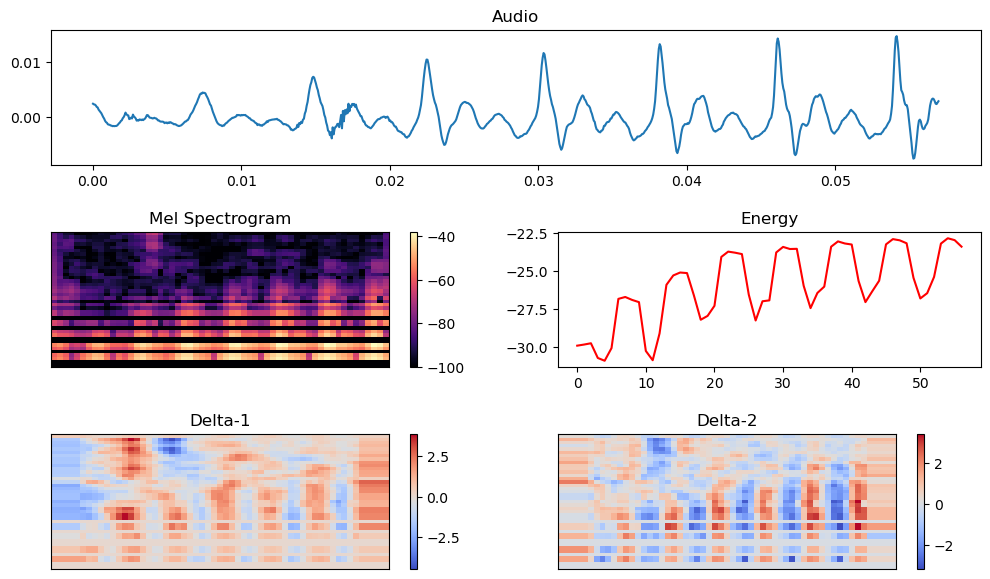

In [13]:
# Plot the features
print('phoneme:', phone)
ipd.display(ipd.Audio(wave, rate=rate))

fig = plt.figure(figsize=(3*4, 7))
fig.subplots_adjust(hspace=0.5)
fig.tight_layout()

ax_wave = fig.add_subplot(3, 1, 1)
plotAudio(wave, rate, ax_wave)
ax_wave.set_title('Audio')

ax_mel = fig.add_subplot(3, 2, 3)
ax_mel.set_title('Mel Spectrogram')
plotSpecshow(mel_spec, fig, ax_mel)

ax_energy = fig.add_subplot(3, 2, 4)
ax_energy.set_title('Energy')
ax_energy.plot(energy[0], color='r')

ax_delta1 = fig.add_subplot(3, 2, 5)
ax_delta1.set_title('Delta-1')
plotSpecshow(delta1, fig, ax_delta1)

ax_delta2 = fig.add_subplot(3, 2, 6)
ax_delta2.set_title('Delta-2')
plotSpecshow(delta2, fig, ax_delta2)

In [14]:
# delete redundant variables to avoid confusion
del rec, phone, wave, rate
del mel_spec, energy, mel_eng, delta1, delta2
del ax_wave, ax_mel, ax_energy, ax_delta1, ax_delta2, fig

## Check Audio Dataset Distribution

Check the audio dataset to determine the parameters for the features.  

In [15]:
from math import inf as INF


# Given a audio dataset, returns the record with min and max audio lengths
def getMinMaxRec(ds_list):
    min_len = INF
    max_len = -INF
    min_rec = None
    max_rec = None
    all_len = []
    for audio_rec in ds_list:    # rec: (phoneme, wave, rate)
        phone_len = len(audio_rec[1])
        if phone_len < min_len:
            min_len = phone_len
            min_rec = audio_rec
        if phone_len > max_len:
            max_len = phone_len
            max_rec = audio_rec
        all_len.append(phone_len)
    return min_len, max_len, min_rec, max_rec, all_len


# Given an audio dataset, shows the audio length disribution
def showAudioLenDisrib(audio_ds):
    # Print min/max info
    min_len, max_len, min_rec, max_rec, all_len = getMinMaxRec(audio_ds)
    print('min_rec:', min_len, min_rec[0])
    print('max_rec:', max_len, max_rec[0])
    median = np.median(all_len)
    print('median:', median)
    
    # show min-rec waveform
    wave, rate = min_rec[1:]
    print('min_rec waveform:')
    plt.plot(wave)
    plt.show()
    
    # Play the audio clips
    ipd.display(ipd.Audio(wave, rate=rate))
    wave, rate = max_rec[1:]
    ipd.display(ipd.Audio(wave, rate=rate))
    
    # Show the histogram
    plt.hist(all_len, bins='auto', rwidth=0.8)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of audio lengths')

Train_audio_ds ---
min_rec: 32 h#
max_rec: 38345 h#
median: 1065.0
min_rec waveform:


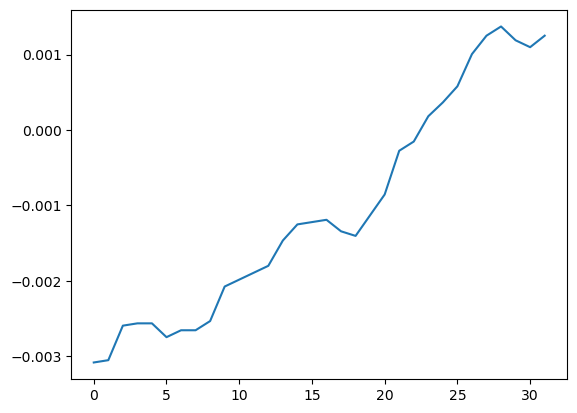

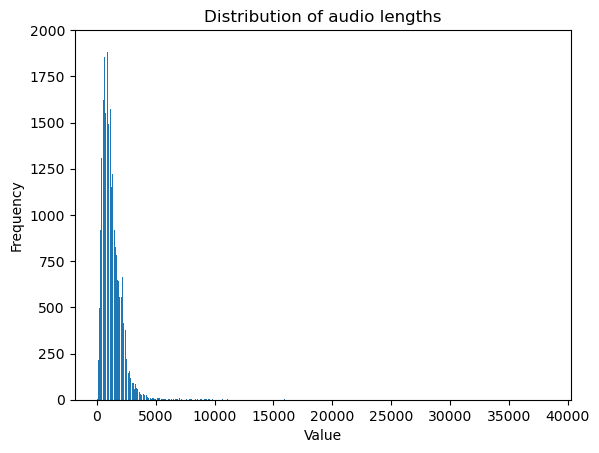

In [16]:
print('Train_audio_ds ---')
showAudioLenDisrib(Train_audio_ds)

Test_audio_ds ---
min_rec: 38 d
max_rec: 16810 h#
median: 1042.0
min_rec waveform:


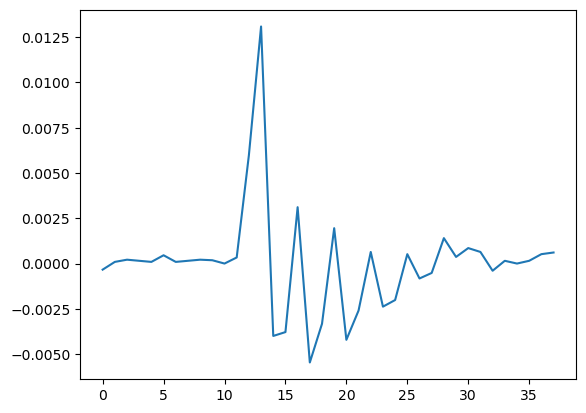

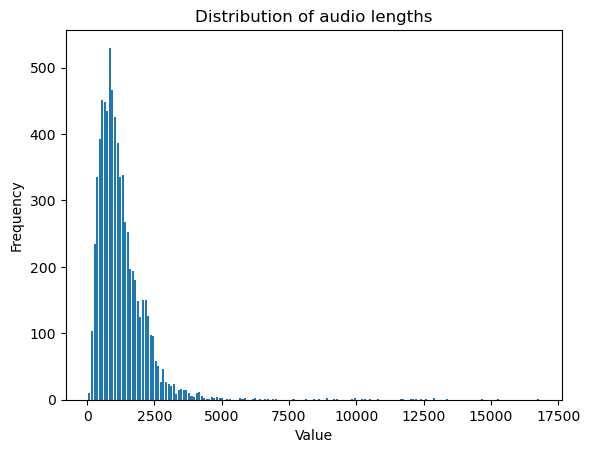

In [17]:
print('Test_audio_ds ---')
showAudioLenDisrib(Test_audio_ds)

## Zero Padding of Short Audio

**NOTE:**
Based on the above observation
- Because median is around 1024, pad zeros to make all audio length >= 1024.

In [18]:
# Given an audio dataset, pad zeros to make all audio clips lengths >= min_len
# audio_ds[i]: (phoneme, wave, rate)
def padZeroAudio(audio_ds, min_len):
    for audio_rec in audio_ds:
        current_length = len(audio_rec[1])
        if current_length < min_len:
            num_zeros = min_len - current_length
            padding = np.zeros(num_zeros)
            padded_audio = np.concatenate((audio_rec[1], padding))
            audio_rec[1] = padded_audio

            
# Pad zeros to audio
F_min_audio_len = 1024
padZeroAudio(Train_audio_ds, F_min_audio_len)
padZeroAudio(Test_audio_ds, F_min_audio_len)    

Train_audio_ds ---
min_rec: 1024 l
max_rec: 38345 h#
median: 1065.0
min_rec waveform:


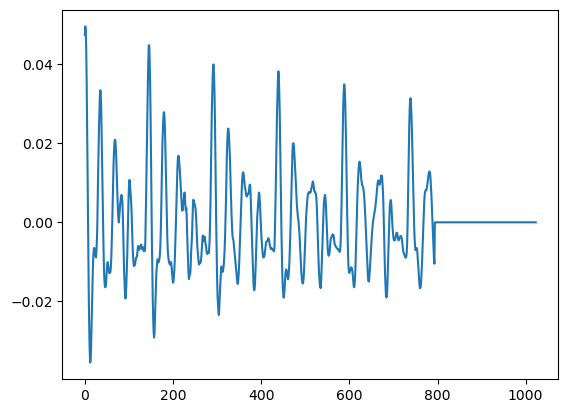

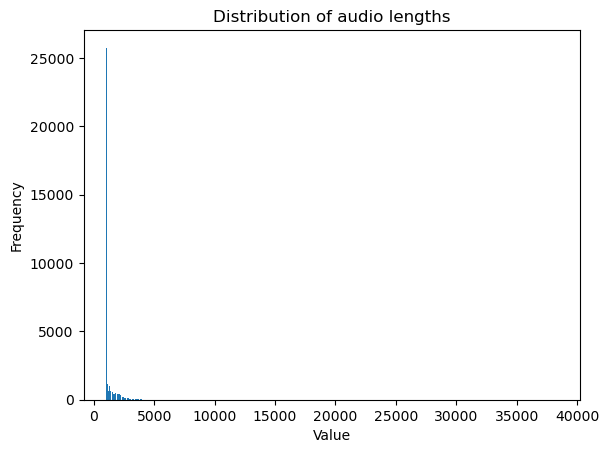

In [19]:
print('Train_audio_ds ---')
showAudioLenDisrib(Train_audio_ds)

Test_audio_ds ---
min_rec: 1024 dh
max_rec: 16810 h#
median: 1042.0
min_rec waveform:


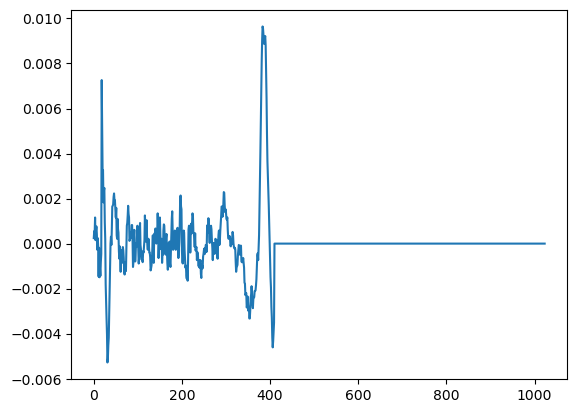

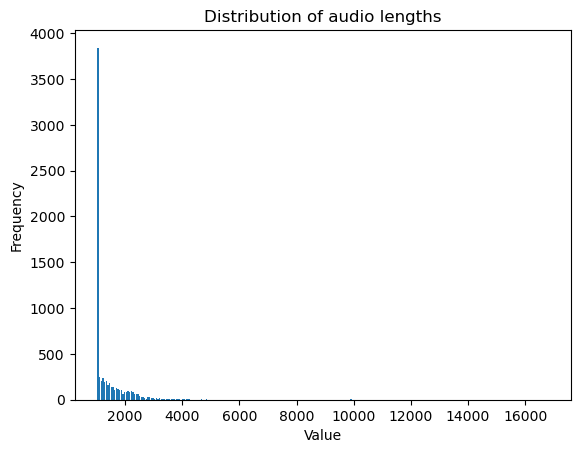

In [20]:
print('Test_audio_ds ---')
showAudioLenDisrib(Test_audio_ds)

# Feature Extraction, Normalization, and Export

## Build Feature Dataset

In [21]:
F_fft_window = 256
F_hop_length = 64
F_n_mels = 40

F_note = f'''
F_n_mels    : {F_n_mels}
F_fft_window: {F_fft_window}
F_hop_length: {F_hop_length}
'''

# Given an audio record, returns a feature record: (phoneme, feature-sequence)
def getFeatureRecord(audio_record):
    # Feature extraction parameters
    # Extract features from the audio-record
    phone, wave, rate = audio_record
    # compute mel-spectrogram
    mel_spec = getMelSpec(wave, rate, n_mels=F_n_mels, fft_window=F_fft_window, hop_length=F_hop_length)
    # Compute energy from mfcc then stack on top of mfcc for deta calculation
    energy = getEnergy(wave, frame_length=F_fft_window, hop_length=F_hop_length)
    mel_eng = np.vstack([mel_spec, energy])
    # compute deltas
    delta1 = getDelta(mel_eng, order=1)
    delta2 = getDelta(mel_eng, order=2)
    # stack all to make feature vector
    feat_vec = np.vstack([mel_eng, delta1, delta2])
    return [phone, feat_vec]    # make each record a list, not a tuple for easier modification later

    
# Test above function
audio_rec = Train_audio_ds[4]
phone, feat_vec = getFeatureRecord(audio_rec)
print('phone:', phone)
print('audio_rec[1]:', len(audio_rec[1]))
print('feat_vec:', feat_vec.shape)
F_feat_len = len(feat_vec)
ipd.display(ipd.Audio(audio_rec[1], rate=audio_rec[2]))


# delete redundant variables to avoid confusion
del audio_rec, phone, feat_vec

phone: r
audio_rec[1]: 1379
feat_vec: (123, 22)


In [22]:
# Given a feature-sequence, breaks down different parts then plots it
def showFeatures(feature_sequence):    # feature_sequence: (sequence-point, feature-vector)    
    feat_seq = feature_sequence
    fig = plt.figure(figsize=(12, 5))
    fig.subplots_adjust(hspace=0.5)
    fig.tight_layout()

    mel_coeff = feat_seq[0:40, :]     # extract the mel coefficients only
    ax_mel = fig.add_subplot(2, 2, 1)
    ax_mel.set_title('Mel Coefficients')
    plotSpecshow(mel_coeff, fig, ax_mel)

    energy = feat_seq[40, :]     # extract energy only
    ax_energy = fig.add_subplot(2, 2, 2)
    ax_energy.set_title('Energy')
    ax_energy.plot(energy)
    
    delta1 = feat_seq[41:82, :]  # extract delta1 only
    ax_delta1 = fig.add_subplot(2, 2, 3)
    ax_delta1.set_title('Delta-1')
    plotSpecshow(delta1, fig, ax_delta1)

    delta2 = feat_seq[82:, :]    # extract delta2 only
    ax_delta2 = fig.add_subplot(2, 2, 4)
    ax_delta2.set_title('Delta-2')
    plotSpecshow(delta2, fig, ax_delta2)
    


In [23]:
# Given an audio dataset, returns a list of feature dataset
# audio_ds[i]: (phone, wave, rate)
# return[i]: (phone, feature-sequence)
def makeFeatureDS(audio_ds):
    feat_ds = []
    for audio_rec in tqdm(audio_ds):
        feat_rec = getFeatureRecord(audio_rec)
        feat_ds.append(feat_rec)
    return feat_ds


# Build feature datasets
Train_feat_ds     = makeFeatureDS(Train_audio_ds)
Test_feat_ds      = makeFeatureDS(Test_audio_ds)

  0%|          | 0/51848 [00:00<?, ?it/s]

  0%|          | 0/7333 [00:00<?, ?it/s]

s


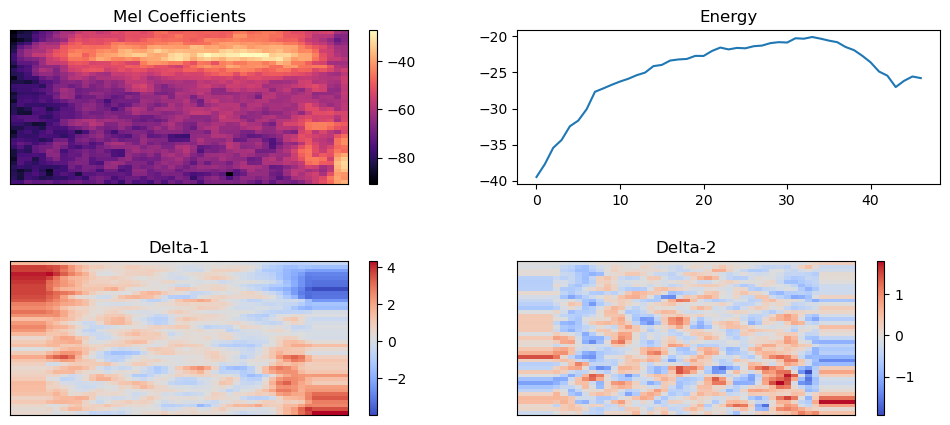

In [24]:
item = Train_feat_ds[1]
print(item[0])
showFeatures(item[1])
del item

## Normalize

mean: -32.150614882744634    std: 22.91406544423349


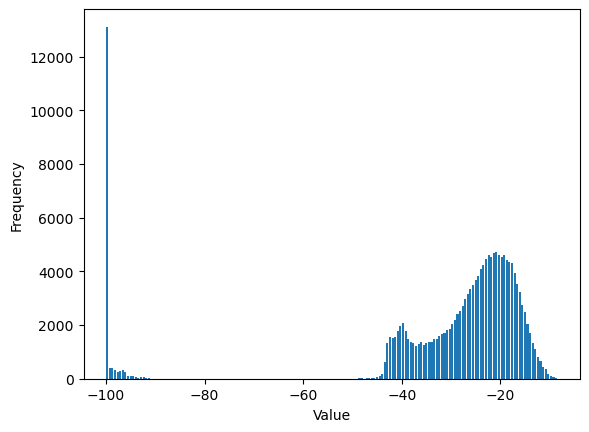

In [25]:
# Given a list of sequences, flattens it into a 1D array
def makeFlattened(sequence_list):
    # merge and flatten
    out_list = []
    for index, seq in enumerate(sequence_list):
        out_list.append(seq.flatten())        # make flattened copies of the sequences
    out_list = np.concatenate(out_list)
    out_list = out_list.flatten()
    return out_list
    

# Given a list of features, returns their mean and standard deviation
def getMeanStd(all_features, flattened=False):
    # merge and flatten if necessary
    if not flattened: all_features = makeFlattened(all_features)
    # Get mean and standard deviation
    mean = np.mean(all_features)
    std  = np.std(all_features)
    return mean, std


# Show the histogram
def plotHistogram(array):
    plt.hist(array, bins='auto', rwidth=0.8)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
        
# Given a feature-dataset, returns different parts of the feature vector as lists
def separateFeatures(feat_ds):
    all_mel = [item[1][0:40, :] for item in feat_ds]
    all_energy = [item[1][40, :] for item in feat_ds]
    all_delta1 = [item[1][41:82, :] for item in feat_ds]
    all_delta2 = [item[1][82:123, :] for item in feat_ds]
    return all_mel, all_energy, all_delta1, all_delta2




# Test above function
all_mel, all_energy, all_delta1, all_delta2 = separateFeatures(Test_feat_ds)
array = makeFlattened(all_energy)
mean, std = getMeanStd(array)
plotHistogram(array)
print('mean:', mean, "   std:", std)
del all_mel, all_energy, all_delta1, all_delta2
del array, mean, std

In [26]:
# Given a list of features, returns dynarmic range-related parameters
def getDynRange(all_features):
    # Merge and Flatten
    all_features = makeFlattened(all_features)
    all_feat_0 = all_features[all_features!=0]     # remove all zeros
    # Compute dynamic range-related information
    min_all = np.min(all_features)
    max_all = np.max(all_features)
    min_abs = np.min(np.abs(all_features))
    max_abs = np.max(np.abs(all_features))
    min_abs_0 = np.min(np.abs(all_feat_0))
    mean, std = getMeanStd(all_features, flattened=True)
    return min_all, max_all, min_abs, max_abs, min_abs_0, mean, std


# Printing utility for dynamic range parameters
def printDynRangeParams(min_all, max_all, min_abs, max_abs, min_abs_0, mean, std):
    print('min_all  :', min_all)
    print('max_all  :', max_all)
    print('min_abs  :', min_abs)
    print('max_abs  :', max_abs)
    print('min_abs_0:', min_abs_0)
    print('mean     :', mean)
    print('std      :', std)

    
# Given a feature-dataset, prints the dynamic ranges of different sections of the feature-vector
def printAllRange(feat_ds):
    all_feat = [item[1] for item in feat_ds]
    all_mel, all_energy, all_delta1, all_delta2 = separateFeatures(feat_ds)
     
    # Dynamic range of entire feature vector
    range_params = getDynRange(all_feat)
    print('[all_feat]')
    printDynRangeParams(*range_params)

    # Dynamic range of mel-coefficients
    range_params = getDynRange(all_mel)
    print('\n[all_mel]')
    printDynRangeParams(*range_params)

    # Dynamic range of energy
    range_params = getDynRange(all_energy)
    print('\n[all_energy]')
    printDynRangeParams(*range_params)

    # Dynamic range of delta-1
    range_params = getDynRange(all_delta1)
    print('\n[all_delta1]')
    printDynRangeParams(*range_params)

    # Dynamic range of delta-2
    range_params = getDynRange(all_delta2)
    print('\n[all_delta2]')
    printDynRangeParams(*range_params)
    

    
    
# Print the dynamic ranges before normalization
print('Dynamic Ranges before normalization')
print('---- Test_feat_ds ----')
printAllRange(Test_feat_ds)

Dynamic Ranges before normalization
---- Test_feat_ds ----
[all_feat]
min_all  : -100.0
max_all  : 10.831764204027728
min_abs  : 0.0
max_abs  : 100.0
min_abs_0: 2.5065329543006704e-16
mean     : -20.60832680905366
std      : 31.16598904046494

[all_mel]
min_all  : -100.0
max_all  : 0.23370049893856049
min_abs  : 0.01657063513994217
max_abs  : 100.0
min_abs_0: 0.01657063513994217
mean     : -61.43020024415578
std      : 21.71788423128575

[all_energy]
min_all  : -100.0
max_all  : -8.445880889892578
min_abs  : 8.445880889892578
max_abs  : 100.0
min_abs_0: 8.445880889892578
mean     : -32.150614882744634
std      : 22.91406544423349

[all_delta1]
min_all  : -13.32323729197184
max_all  : 10.831764204027728
min_abs  : 0.0
max_abs  : 13.32323729197184
min_abs_0: 2.9530394879928144e-16
mean     : -0.9846157461296258
std      : 2.4305455235226154

[all_delta2]
min_all  : -8.876262078245801
max_all  : 6.4270548820495605
min_abs  : 0.0
max_abs  : 8.876262078245801
min_abs_0: 2.5065329543006704e-

In [27]:
print('---- Train_feat_ds ----')
printAllRange(Train_feat_ds)

---- Train_feat_ds ----
[all_feat]
min_all  : -100.0
max_all  : 10.59018325805664
min_abs  : 0.0
max_abs  : 100.0
min_abs_0: 2.5065329543006704e-16
mean     : -20.576199780691063
std      : 31.129785562607744

[all_mel]
min_all  : -100.0
max_all  : 4.408583164215088
min_abs  : 0.0010956323239952326
max_abs  : 100.0
min_abs_0: 0.0010956323239952326
mean     : -61.361719781197934
std      : 21.679223562761457

[all_energy]
min_all  : -100.0
max_all  : -6.908526420593262
min_abs  : 6.908526420593262
max_abs  : 100.0
min_abs_0: 6.908526420593262
mean     : -31.935273795478487
std      : 22.519792966683003

[all_delta1]
min_all  : -13.331580098470049
max_all  : 10.59018325805664
min_abs  : 0.0
max_abs  : 13.331580098470049
min_abs_0: 2.6328452154447506e-16
mean     : -0.9490855965902376
std      : 2.4223143048604645

[all_delta2]
min_all  : -9.358959809115131
max_all  : 7.116988658905029
min_abs  : 0.0
max_abs  : 9.358959809115131
min_abs_0: 2.5065329543006704e-16
mean     : -0.135512159058

In [28]:
from copy import deepcopy


# Given a feature dataset, returns the mean and std of each feature subset
def getNormalizationParams(feature_ds):
    all_mel, all_energy, all_delta1, all_delta2 = separateFeatures(feature_ds)
    mel_mean, mel_std = getMeanStd(all_mel)
    eng_mean, eng_std = getMeanStd(all_energy)
    d1_mean, d1_std = getMeanStd(all_delta1)
    d2_mean, d2_std = getMeanStd(all_delta2)        
    return (mel_mean, mel_std), (eng_mean, eng_std), (d1_mean, d1_std), (d2_mean, d2_std)


# Given a feature dataset and normalization parameters, normalizes the feature subsets
def normalizeFeatures(feature_ds, normal_params):
    # Unpack normalization parameters
    (mel_mean, mel_std), \
    (eng_mean, eng_std), \
    (d1_mean, d1_std), \
    (d2_mean, d2_std)  = normal_params
    eps = 1e-4            # replacement for zero
    feat_ds_copy = deepcopy(feature_ds)    # don't modify original dataset
    
    # Normalize mel-coefficients
    mean, std = mel_mean, mel_std
    print(f'INFO: Normalizing mel-coefficients, mean: {mean}   std: {std}')
    if std == 0: std = eps           # avoid division by zero
    for item in feat_ds_copy:
        mels = item[1][0:40, :]
        item[1][0:40, :] = (mels - mean) / std
    
    # normalize energy
    mean, std = eng_mean, eng_std
    print(f'INFO: Normalizing energy, mean: {mean}   std: {std}')
    if std == 0: std = eps           # avoid division by zero
    for item in feat_ds_copy:
        energy = item[1][40, :]
        item[1][40, :] = (energy - mean) / std
    
    # normalize delta-1
    mean, std = d1_mean, d1_std
    print(f'INFO: Normalizing delta-1, mean: {mean}   std: {std}')
    if std == 0: std = eps           # avoid division by zero
    for item in feat_ds_copy:
        delta1 = item[1][41:82, :]
        item[1][41:82, :] = (delta1 - mean) / std
    
    # normalize delta-2
    mean, std = d2_mean, d2_std
    print(f'INFO: Normalizing delta-2, mean: {mean}   std: {std}')
    if std == 0: std = eps           # avoid division by zero
    for item in feat_ds_copy:
        delta2 = item[1][82:123, :]
        item[1][82:123, :] = (delta2 - mean) / std
        
    return feat_ds_copy

In [29]:
# Normalize Train and Test features using Train normalization parameters
train_normal_params = getNormalizationParams(Train_feat_ds)
Test_norm_feat_ds = normalizeFeatures(Test_feat_ds, normal_params=train_normal_params)
Train_norm_feat_ds = normalizeFeatures(Train_feat_ds, normal_params=train_normal_params)

INFO: Normalizing mel-coefficients, mean: -61.361719781197934   std: 21.679223562761457
INFO: Normalizing energy, mean: -31.935273795478487   std: 22.519792966683003
INFO: Normalizing delta-1, mean: -0.9490855965902376   std: 2.4223143048604645
INFO: Normalizing delta-2, mean: -0.13551215905890834   std: 1.161599121614447
INFO: Normalizing mel-coefficients, mean: -61.361719781197934   std: 21.679223562761457
INFO: Normalizing energy, mean: -31.935273795478487   std: 22.519792966683003
INFO: Normalizing delta-1, mean: -0.9490855965902376   std: 2.4223143048604645
INFO: Normalizing delta-2, mean: -0.13551215905890834   std: 1.161599121614447


In [30]:
print('\nDynamic Ranges after normalization')
print('---- Test_norm_feat_ds ----')
printAllRange(Test_norm_feat_ds)


Dynamic Ranges after normalization
---- Test_norm_feat_ds ----
[all_feat]
min_all  : -7.524755964896541
max_all  : 5.64959716796875
min_abs  : 2.5656287760966734e-08
max_abs  : 7.524755964896541
min_abs_0: 2.5656287760966734e-08
mean     : -0.0027770149448767306
std      : 1.003821144297106

[all_mel]
min_all  : -1.7822723266331038
max_all  : 2.841218948364258
min_abs  : 1.7596096313354792e-07
max_abs  : 2.841218948364258
min_abs_0: 1.7596096313354792e-07
mean     : -0.0031587715603046585
std      : 1.0017833023708522

[all_energy]
min_all  : -3.0224401398902803
max_all  : 1.043055534362793
min_abs  : 3.0067272746236995e-05
max_abs  : 3.0224401398902803
min_abs_0: 3.0067272746236995e-05
mean     : -0.009562290077063041
std      : 1.017507825565856

[all_delta1]
min_all  : -5.1084005368553544
max_all  : 4.863468698912956
min_abs  : 2.4606484316791466e-07
max_abs  : 5.1084005368553544
min_abs_0: 2.4606484316791466e-07
mean     : -0.0146678628653864
std      : 1.0033980705983763

[all_de

In [31]:
print('---- Train_norm_feat_ds ----')
printAllRange(Train_norm_feat_ds)

---- Train_norm_feat_ds ----
[all_feat]
min_all  : -7.940301846334926
max_all  : 6.24354887008667
min_abs  : 9.528192378907992e-10
max_abs  : 7.940301846334926
min_abs_0: 9.528192378907992e-10
mean     : 7.286157533339265e-09
std      : 0.9999999935403501

[all_mel]
min_all  : -1.7822723266331038
max_all  : 3.0337941646575928
min_abs  : 1.205971995058448e-07
max_abs  : 3.0337941646575928
min_abs_0: 1.205971995058448e-07
mean     : 3.504062449544966e-08
std      : 0.9999999967797446

[all_energy]
min_all  : -3.0224401398902803
max_all  : 1.1113224029541016
min_abs  : 1.547985032576496e-07
max_abs  : 3.0224401398902803
min_abs_0: 1.547985032576496e-07
mean     : 1.3202168356516307e-08
std      : 1.0000000058197378

[all_delta1]
min_all  : -5.1118446838355664
max_all  : 4.763736724853516
min_abs  : 4.9212971475753875e-08
max_abs  : 5.1118446838355664
min_abs_0: 4.9212971475753875e-08
mean     : -1.021586963751146e-08
std      : 0.999999989908413

[all_delta2]
min_all  : -7.940301846334926

aa


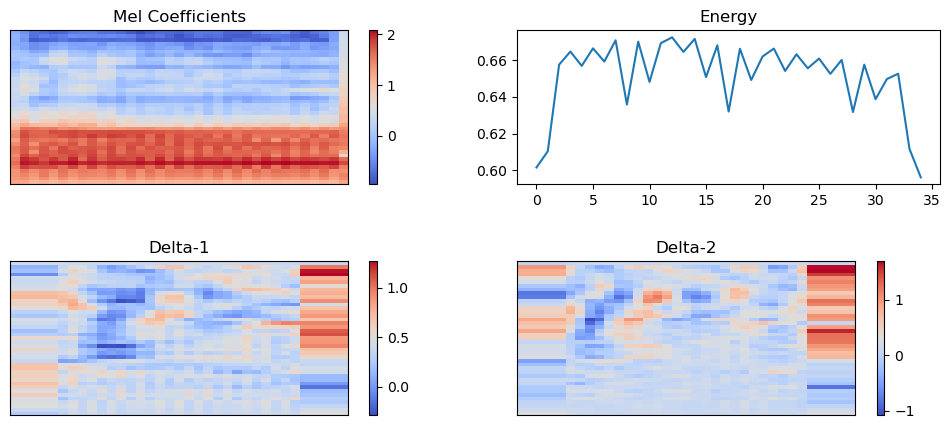

In [36]:
Normal_params = train_normal_params   # save for later use
item = Train_norm_feat_ds[2]
print(item[0])
showFeatures(item[1])

In [37]:
del item, train_normal_params

## Export Normalized Feature Datasets

In [38]:
# Delete extra datasets to save memory
del Train_ds, Train_feat_ds
del Test_ds, Test_feat_ds

In [39]:
# Export the dataset with necessary information for the next notebook
normal_param_scheme = '(mel_mean, mel_std), (eng_mean, eng_std), (d1_mean, d1_std), (d2_mean, d2_std)'
note = f'''
Notes:
- Feature record: (phone, feature_sequence)
- Feature_seqence: list(feature_vector)
- Normalization params: {normal_param_scheme}
- len(feature_vector): {F_feat_len}

Normalization Parameters:
{Normal_params}

Features are extracted using following parameters''' + F_note

print(note)


Notes:
- Feature record: (phone, feature_sequence)
- Feature_seqence: list(feature_vector)
- Normalization params: (mel_mean, mel_std), (eng_mean, eng_std), (d1_mean, d1_std), (d2_mean, d2_std)
- len(feature_vector): 123

Normalization Parameters:
((-61.361719781197934, 21.679223562761457), (-31.935273795478487, 22.519792966683003), (-0.9490855965902376, 2.4223143048604645), (-0.13551215905890834, 1.161599121614447))

Features are extracted using following parameters
F_n_mels    : 40
F_fft_window: 256
F_hop_length: 64



In [40]:
# Given a feature-dataset, saves in a file
def saveFeatureDS(feat_ds, save_path, note):
    export = {
        'note' : note,
        'data-schema' : '(phoneme, feature-sequence)',
        'normal_params' : Normal_params,
        'data' : feat_ds
    }
    torch.save(export, save_path)
    print(f'INFO: Saved {save_path}')

In [41]:
# Make test feature dataset then save
saveFeatureDS(Test_norm_feat_ds, './session/test-norm-features.pt', note)

INFO: Saved ./session/test-norm-features.pt


In [42]:
saveFeatureDS(Train_norm_feat_ds, './session/train-norm-features.pt', note)

INFO: Saved ./session/train-norm-features.pt


# Data Augmentation

Data augmentation is performed to avoid over-fitting on the training dataset. This can potentially improve accuracy over the unknown data points.

## Design Augmentations

In [ ]:
# Adds noise to the audio
def add_noise(waveform, noise_factor):
    noise = np.random.rand(len(waveform))
    noisy_audio = waveform + noise_factor * noise
    return noisy_audio


# Changes the audio volume
def change_volume(waveform, volume_factor):  
    scaled_audio = waveform * volume_factor
    return scaled_audio


# Shifts audio pitch
def pitch_shift(waveform, sample_rate, n_steps):
    shifted_audio = librosa.effects.pitch_shift(waveform, sr=sample_rate, n_steps=n_steps, n_fft=256)
    return shifted_audio


# Increases the audio speed
def speed_change(waveform, speed):
    speedup_audio = librosa.effects.time_stretch(waveform, rate=speed, n_fft=256)
    return speedup_audio
    

In [ ]:
audio_keys = list(audio_cache.keys())
wave, rate = audio_cache[audio_keys[100]]
print('original audio')
ipd.Audio(wave, rate=rate)

In [ ]:
# Applies the augmentation and shows the audio widget with the new waveform
def testAugmentation(augmenter, waveform, rate, **options):
    new_wave = augmenter(waveform, **options)
    ipd.display(ipd.Audio(new_wave, rate=rate))
    ax_org = plt.subplot(1,2,1)
    ax_new = plt.subplot(1,2,2)
    ax_org.plot(waveform)
    ax_new.plot(new_wave)
    plt.show()
    
    

# Test the augmentations
print('add_noise')
testAugmentation(add_noise, wave, rate, noise_factor=0.002)  # factor range: 0.002 - 0.005

In [ ]:
print('change_volume')
testAugmentation(change_volume, wave, rate, volume_factor=1.5)  # factor range: 0.2 - 1.5

In [ ]:
print('pitch_shift')
testAugmentation(pitch_shift, wave, rate, sample_rate=rate, n_steps=2)    # n_steps: -2 to 2

In [ ]:
print('speed_change')
testAugmentation(speed_change, wave, rate, speed=0.85)   # speed range: 0.85 - 1.2

In [ ]:
del audio_keys, wave, rate

## Build Augmented Audio Dataset

In [ ]:
# Define augmentation functions with randomized parameters
import random


def augment_noise(waveform, rate):
    factor_min, factor_max = 0.002, 0.005
    factor = random.uniform(factor_min, factor_max)
    return add_noise(waveform, noise_factor=factor)


def augment_volume(waveform, rate):
    factor_min, factor_max = 0.2, 1.5
    factor = random.uniform(factor_min, factor_max)
    return change_volume(waveform, volume_factor=factor)


def augment_pitch(waveform, rate):
    step_min, step_max = 0.2, 1.5
    step = random.uniform(-2, 2)
    return pitch_shift(waveform, sample_rate=rate, n_steps=step)


def augment_speed(waveform, rate):
    speed_min, speed_max = 0.85, 1.2
    speed = random.uniform(speed_min, speed_max)
    return speed_change(waveform, speed=speed)
    

    
# Given an audio dataset and a set of augmentations functions
# returns a new dataset with random augmentations applied.
# prototype of all_augments[i]: (waveform, rate)
def makeAugmentedDS(audio_ds, all_augments):
    rmin, rmax = 0, len(all_augments) - 1     # index range for selection
    new_audio_ds = []
    for item in tqdm(audio_ds):
        augment_select = random.randint(rmin, rmax)
        phone, wave, rate = item
        new_wave = all_augments[augment_select](wave, rate)
        new_audio_ds.append([phone, new_wave, rate])
    return new_audio_ds
    
    
    
#Train_audio_ds = makeAudioDS(Train_ds)
Train_aug_audio_ds = makeAugmentedDS(Train_audio_ds, [augment_noise, augment_volume, augment_pitch, augment_speed])
print('Train_aug_audio_ds:', len(Train_aug_audio_ds))

In [ ]:
select_index = 2
item = Train_audio_ds[select_index]
ipd.display(ipd.Audio(item[1], rate=item[2]))

item = Train_aug_audio_ds[select_index]
ipd.display(ipd.Audio(item[1], rate=item[2]))

del select_index, item

In [ ]:
Train_aug_feat_ds = makeFeatureDS(Train_aug_audio_ds)

In [ ]:
print('---- Before normalization: Train_aug_feat_ds ----')
printAllRange(Train_aug_feat_ds)

In [ ]:
Train_norm_aug_feat_ds = normalizeFeatures(Train_aug_feat_ds, normal_params=train_normal_params)

print('---- After normalization: Train_norm_aug_feat_ds ----')
printAllRange(Train_norm_aug_feat_ds)

In [ ]:
saveFeatureDS(Train_norm_aug_feat_ds, './session/train-norm-aug-features.pt', note)